In [11]:
%reset
%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [12]:
import numpy as np
import scipy.io as sio
import netCDF4 as nc
import glob, os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib.colors as mcolors
import xarray as xr

#Creating red colormap
colors = plt.cm.Reds(np.linspace(0, 1, 256))
colors[0,:]=(1.0, 1.0, 1.0, 1.0)
Red = mcolors.LinearSegmentedColormap.from_list('colormap', colors)


In [13]:
print(colors.shape)

(256, 4)


In [14]:
ds = xr.open_mfdataset(['state1.nc','state2.nc','state3.nc'])
tr = xr.open_mfdataset(['tracer1.nc','tracer2.nc','tracer3.nc'])
#ds = xr.open_mfdataset('state10m.nc')
#tr = xr.open_mfdataset('tracer10m.nc')
print(ds)
print(tr)


<xarray.Dataset>
Dimensions:  (T: 243, X: 2560, Xp1: 2561, Y: 1, Yp1: 2, Z: 480, Zl: 480)
Coordinates:
  * Xp1      (Xp1) float64 7.105e-15 28.12 56.24 ... 7.496e+04 7.499e+04
  * Y        (Y) float64 10.0
  * Z        (Z) float64 -1.649 -4.948 -8.247 ... -2.472e+03 -2.483e+03
  * X        (X) float64 14.06 42.18 70.3 ... 7.491e+04 7.494e+04 7.498e+04
  * Yp1      (Yp1) float64 0.0 20.0
  * Zl       (Zl) float64 0.0 -3.299 -6.597 ... -2.456e+03 -2.467e+03 -2.478e+03
  * T        (T) float64 0.0 2.16e+04 4.32e+04 ... 5.141e+06 5.162e+06 5.184e+06
Data variables:
    iter     (T) int32 dask.array<shape=(243,), chunksize=(81,)>
    U        (T, Z, Y, Xp1) float32 dask.array<shape=(243, 480, 1, 2561), chunksize=(81, 480, 1, 2561)>
    V        (T, Z, Yp1, X) float32 dask.array<shape=(243, 480, 2, 2560), chunksize=(81, 480, 2, 2560)>
    Temp     (T, Z, Y, X) float32 dask.array<shape=(243, 480, 1, 2560), chunksize=(81, 480, 1, 2560)>
    S        (T, Z, Y, X) float32 dask.array<shape=(243, 

In [15]:
xq=ds['X']
zl=ds['Zl']
tracer = np.squeeze(tr.tracer)
salt = np.squeeze(ds.S)
temp = np.squeeze(ds.Temp)
u = np.squeeze(ds.U)
v = np.squeeze(ds.V[:,:,0,:])
w = np.squeeze(ds.W)

#Creating topography mask
mask=np.array(salt[0,:,:]); mask[mask>0]=np.nan; mask[mask==0]=1.0

In [16]:
# $Header: /u/gcmpack/MITgcm/utils/python/MITgcmutils/MITgcmutils/jmd95.py,v 1.1 2012/10/25 23:31:30 jahn Exp $
# $Name:  $
#
# created by mlosch on 2002-08-09
# converted to python by jahn on 2010-04-29

import sys
import numpy as np

__doc__ = """
Density of Sea Water using Jackett and McDougall 1995 (JAOT 12) polynomial
Functions:
dens :: computes in-situ density from salinity, potential temperature
        and pressure
"""

# coefficients nonlinear equation of state in pressure coordinates for
# 1. density of fresh water at p = 0
eosJMDCFw = [ 999.842594,
              6.793952e-02,
           -  9.095290e-03,
              1.001685e-04,
           -  1.120083e-06,
              6.536332e-09,
            ]
# 2. density of sea water at p = 0
eosJMDCSw = [     8.244930e-01,
               -  4.089900e-03,
                  7.643800e-05,
               -  8.246700e-07,
                  5.387500e-09,
               -  5.724660e-03,
                  1.022700e-04,
               -  1.654600e-06,
                  4.831400e-04,
            ]
# coefficients in pressure coordinates for
# 3. secant bulk modulus K of fresh water at p = 0
eosJMDCKFw = [    1.965933e+04,
                  1.444304e+02,
                - 1.706103e+00,
                  9.648704e-03,
                - 4.190253e-05,
             ]
# 4. secant bulk modulus K of sea water at p = 0
eosJMDCKSw = [    5.284855e+01,
                - 3.101089e-01,
                  6.283263e-03,
                - 5.084188e-05,
                  3.886640e-01,
                  9.085835e-03,
                - 4.619924e-04,
             ]
# 5. secant bulk modulus K of sea water at p
eosJMDCKP = [     3.186519e+00,
                  2.212276e-02,
                - 2.984642e-04,
                  1.956415e-06,
                  6.704388e-03,
                - 1.847318e-04,
                  2.059331e-07,
                  1.480266e-04,
                  2.102898e-04,
                - 1.202016e-05,
                  1.394680e-07,
                - 2.040237e-06,
                  6.128773e-08,
                  6.207323e-10,
            ]

def densjmd95(s,theta,p):
    """
    densjmd95    Density of sea water
   =========================================================================
    USAGE:  dens = densjmd95(s,theta,p)
    DESCRIPTION:
       Density of Sea Water using Jackett and McDougall 1995 (JAOT 12)
       polynomial (modified UNESCO polynomial).
    INPUT:  (all must have same dimensions)
      S     = salinity    [psu      (PSS-78)]
      Theta = potential temperature [degree C (IPTS-68)]
      P     = pressure    [dbar]
          (P may have dims 1x1, mx1, 1xn or mxn for S(mxn) )
    OUTPUT:
      dens = density  [kg/m^3]
    AUTHOR:  Martin Losch 2002-08-09  (mlosch@mit.edu)
    check value
    S     = 35.5 PSU
    Theta = 3 degC
    P     = 3000 dbar
    rho   = 1041.83267 kg/m^3
    Jackett and McDougall, 1995, JAOT 12(4), pp. 381-388
    """

    # make sure arguments are floating point
    s = np.asfarray(s)
    t = np.asfarray(theta)
    p = np.asfarray(p)

    # convert pressure to bar
    p = .1*p

    t2 = t*t
    t3 = t2*t
    t4 = t3*t

    if np.any(s<0):
        sys.stderr.write('negative salinity values! setting to nan\n')

            
    s3o2 = s*np.sqrt(s)

    # density of freshwater at the surface
    rho = ( eosJMDCFw[0]
          + eosJMDCFw[1]*t
          + eosJMDCFw[2]*t2
          + eosJMDCFw[3]*t3
          + eosJMDCFw[4]*t4
          + eosJMDCFw[5]*t4*t
          )
    # density of sea water at the surface
    rho = ( rho
           + s*(
                 eosJMDCSw[0]
               + eosJMDCSw[1]*t
               + eosJMDCSw[2]*t2
               + eosJMDCSw[3]*t3
               + eosJMDCSw[4]*t4
               )
           + s3o2*(
                 eosJMDCSw[5]
               + eosJMDCSw[6]*t
               + eosJMDCSw[7]*t2
               )
           + eosJMDCSw[8]*s*s
          )

    rho = rho / (1. - p/bulkmodjmd95(s,t,p))

    return rho


def bulkmodjmd95(s,theta,p):
    """ bulkmod = bulkmodjmd95(s,theta,p)
    """
    # make sure arguments are floating point
    s = np.asfarray(s)
    t = np.asfarray(theta)
    p = np.asfarray(p)

    t2 = t*t
    t3 = t2*t
    t4 = t3*t

    s3o2 = s*np.sqrt(s)

    #p = pressure(i,j,k,bi,bj)*SItoBar
    p2 = p*p
    # secant bulk modulus of fresh water at the surface
    bulkmod = ( eosJMDCKFw[0]
              + eosJMDCKFw[1]*t
              + eosJMDCKFw[2]*t2
              + eosJMDCKFw[3]*t3
              + eosJMDCKFw[4]*t4
              )
    # secant bulk modulus of sea water at the surface
    bulkmod = ( bulkmod
              + s*(      eosJMDCKSw[0]
                       + eosJMDCKSw[1]*t
                       + eosJMDCKSw[2]*t2
                       + eosJMDCKSw[3]*t3
                       )
              + s3o2*(   eosJMDCKSw[4]
                       + eosJMDCKSw[5]*t
                       + eosJMDCKSw[6]*t2
                       )
               )
    # secant bulk modulus of sea water at pressure p
    bulkmod = ( bulkmod
              + p*(   eosJMDCKP[0]
                    + eosJMDCKP[1]*t
                    + eosJMDCKP[2]*t2
                    + eosJMDCKP[3]*t3
                  )
              + p*s*(   eosJMDCKP[4]
                      + eosJMDCKP[5]*t
                      + eosJMDCKP[6]*t2
                    )
              + p*s3o2*eosJMDCKP[7]
              + p2*(   eosJMDCKP[8]
                     + eosJMDCKP[9]*t
                     + eosJMDCKP[10]*t2
                   )
              + p2*s*(  eosJMDCKP[11]
                      + eosJMDCKP[12]*t
                      + eosJMDCKP[13]*t2
                     )
               )

    return bulkmod

dens = densjmd95

In [18]:
g=9.81; rho_o=1028.00; f=1.43e-4;

dx=np.diff(xq); dxmat=np.tile(dx,[480,1])
dz=np.diff(zl); dzmat=np.tile(dz,[2560,1]); dzmat=np.transpose(dzmat)

#EPV1=np.zeros(719); EPV2=np.zeros(719); EPV3=np.zeros(719);
EPVsum=np.zeros(240)
EPVsumneg=np.zeros(240)

for i in range (0,240):
    tempi=np.array(temp[i,:,:]); 
    salti=np.array(salt[i,:,:]); 
    vi=np.squeeze(np.array(v[i,:,:]))
    dens = densjmd95(salti,tempi,0)
    dens[salti==0]=np.nan;
    vi[salti==0]=np.nan;

    drhodx=np.diff(dens,axis=1)/dxmat
    drhodz=np.diff(dens,axis=0)/dzmat
    dvdx=np.diff(vi,axis=1)/dxmat
    dvdz=np.diff(vi,axis=0)/dzmat

    drhodx=drhodx[0:479,0:2559];
    drhodz=drhodz[0:479,0:2559];
    dvdx=dvdx[0:479,0:2559];
    dvdz=dvdz[0:479,0:2559];
    EPV=(g/rho_o)*(drhodx*dvdz)-(g/rho_o)*drhodz*(dvdx+f)
    EPVsum[i]=np.nansum(EPV)
    EPVsumneg[i]=np.nansum(EPV[EPV<0])
    #EPV1[i]=EPV[400,1430]
    #EPV2[i]=EPV[400,1480]
    #EPV3[i]=EPV[400,1530]
      
    print(i)

/nbhome/eay/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in less


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239


(0.0002, 0.001)

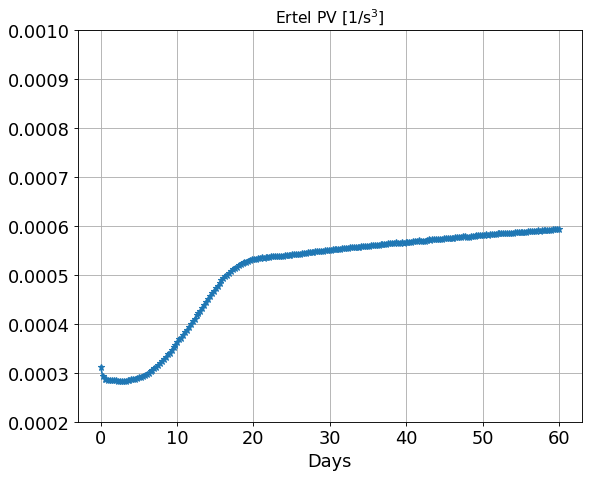

In [24]:
#plt.clear()
fig = plt.figure(figsize=(9, 7), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.1,0.7,0.7])  #left pos. bottom pos. width, height #ax1 = fig.add_subplot(111)


plt.plot(np.linspace(0,60,240),EPVsum[0:240],'-*')
#plt.plot(np.linspace(40,60,80),EPV2[0:80],'-*')
#plt.plot(np.linspace(40,60,80),EPV3[0:80],'-*')
plt.grid()
ax1.set_xlabel('Days',fontsize=16); 
ax1.tick_params(labelsize=16); #ax2.tick_params(labelsize=12);

#EPVneg=EPV; EPVneg[EPVneg>=0]=np.nan;    
#quad1 = ax1.pcolormesh(xq/1000,zl,EPVneg,cmap='RdBu_r',vmin=-1e-20,vmax=1e-10,shading='goaround')
#cb1 = fig.colorbar(quad1,ax2)
ax1.set_title('Ertel PV [1/s$^3$]', fontsize=14)

#ax1.set_ylim(-0.00007,0)
ax1.set_ylim(0.0002,0.001)
#ax1.set_xlim(000,400)
#plt.savefig('index%.3d'%i)


In [9]:
g=9.81; rho_o=1028.00; f=1.43e-4;

dx=np.diff(xq); dxmat=np.tile(dx,[480,1])
dz=np.diff(zl); dzmat=np.tile(dz,[2560,1]); dzmat=np.transpose(dzmat)

for i in (0,12):
    print(i)
    tempi=np.array(temp[i,:,:]); 
    salti=np.array(salt[i,:,:]); 
    vi=np.squeeze(np.array(v[i,:,:]))
    dens = densjmd95(salti,tempi,0)
    dens[salti==0]=np.nan;
    vi[salti==0]=np.nan;

    drhodx=np.diff(dens,axis=1)/dxmat
    drhodz=np.diff(dens,axis=0)/dzmat
    dvdx=np.diff(vi,axis=1)/dxmat
    dvdz=np.diff(vi,axis=0)/dzmat

    drhodx=drhodx[0:479,0:2559];
    drhodz=drhodz[0:479,0:2559];
    dvdx=dvdx[0:479,0:2559];
    dvdz=dvdz[0:479,0:2559];
    EPV=(g/rho_o)*(drhodx*dvdz)-(g/rho_o)*drhodz*(dvdx+f)
    EPV[EPV<0]=-1; EPV[EPV>0]=0;
    if i == 0:
        EPVnegi=EPV
    if i > 0:
        EPVnegf=EPV



0


/nbhome/eay/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in less
/nbhome/eay/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in greater


12


/nbhome/eay/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in greater


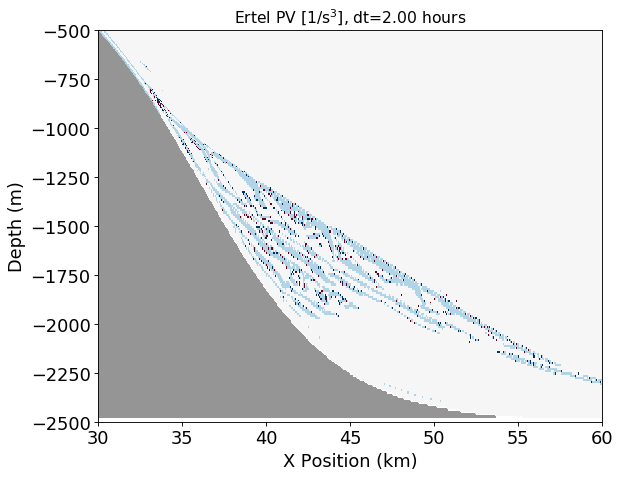

In [12]:
fig = plt.figure(figsize=(9, 7), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.1,0.7,0.7])  #left pos. bottom pos. width, height #ax1 = fig.add_subplot(111)
#ax2 = fig.add_axes([.87, 0.1, 0.05, 0.7])
ax1.invert_yaxis

quad0= ax1.pcolormesh(xq/1000,zl,mask,cmap='Greys',vmin=0,vmax=2.)
ax1.set_xlabel('X Position (km)',fontsize=16); ax1.set_ylabel('Depth (m)',fontsize=16)
ax1.tick_params(labelsize=16); #ax2.tick_params(labelsize=12);

difference = EPVnegf-EPVnegi; product=EPVnegf*EPVnegi; difference[product>0]=-.3
quad1 = ax1.pcolormesh(xq/1000,zl,difference,cmap='RdBu_r',vmin=-1,vmax=1,shading='goaround')
#quad2 = ax1.pcolormesh(xq/1000,zl,EPVnegf*EPVnegi*0.5,cmap='RdBu_r',vmin=-1,vmax=1,shading='goaround')

ax1.set_title('Ertel PV [1/s$^3$], dt=%2.2f hours' %(i/6), fontsize=14)

#ax1.set_ylim(-2500,0)
#ax1.set_xlim(0,60)
ax1.set_ylim(-2500,-500)
ax1.set_xlim(30,60)
plt.savefig('index%.3d'%i)

#LIGHT BLUE: ORIGINALLY NEGATIVE, FINALLY NEGATIVE
#DARK BLUE:  ORIGINALLY POSITIVE, FINALLY NEGATIVE
#RED: ORIGINALLY NEGATIVE, FINALLY POSITIVE

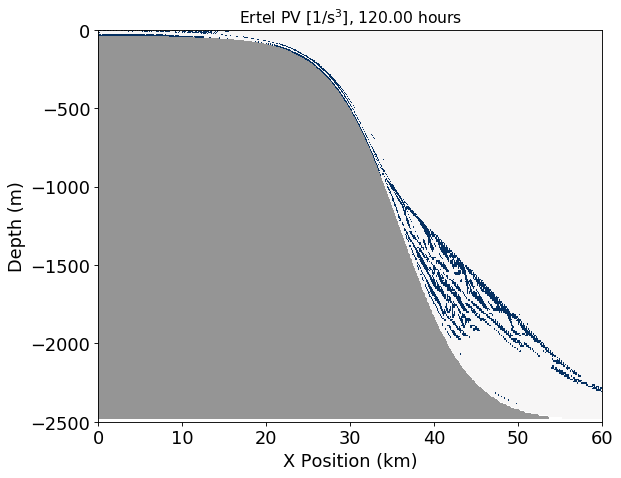

In [49]:
fig = plt.figure(figsize=(9, 7), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.1,0.7,0.7])  #left pos. bottom pos. width, height #ax1 = fig.add_subplot(111)
#ax2 = fig.add_axes([.87, 0.1, 0.05, 0.7])
ax1.invert_yaxis

quad0= ax1.pcolormesh(xq/1000,zl,mask,cmap='Greys',vmin=0,vmax=2.)
ax1.set_xlabel('X Position (km)',fontsize=16); ax1.set_ylabel('Depth (m)',fontsize=16)
ax1.tick_params(labelsize=16); #ax2.tick_params(labelsize=12);
 
quad1 = ax1.pcolormesh(xq/1000,zl,EPVnegi,cmap='RdBu_r',vmin=-1,vmax=1,shading='goaround')
#cb1 = fig.colorbar(quad1,ax2)
ax1.set_title('Ertel PV [1/s$^3$], %2.2f hours' %(i/6), fontsize=14)

ax1.set_ylim(-2500,0)
ax1.set_xlim(0,60)
#ax1.set_ylim(-2500,-500)
#ax1.set_xlim(30,60)
plt.savefig('index%.3d'%i)

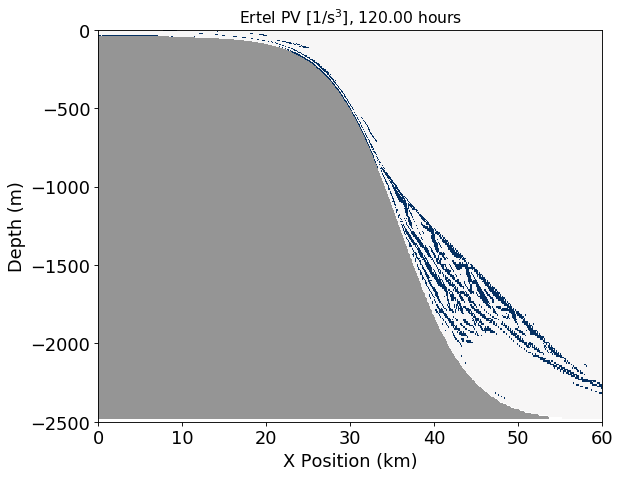

In [14]:
fig = plt.figure(figsize=(9, 7), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.1,0.7,0.7])  #left pos. bottom pos. width, height #ax1 = fig.add_subplot(111)
#ax2 = fig.add_axes([.87, 0.1, 0.05, 0.7])
ax1.invert_yaxis

quad0= ax1.pcolormesh(xq/1000,zl,mask,cmap='Greys',vmin=0,vmax=2.)
ax1.set_xlabel('X Position (km)',fontsize=16); ax1.set_ylabel('Depth (m)',fontsize=16)
ax1.tick_params(labelsize=16); #ax2.tick_params(labelsize=12);
 
quad1 = ax1.pcolormesh(xq/1000,zl,EPVnegf,cmap='RdBu_r',vmin=-1,vmax=1,shading='goaround')
#cb1 = fig.colorbar(quad1,ax2)
ax1.set_title('Ertel PV [1/s$^3$], %2.2f hours' %(i/6), fontsize=14)

ax1.set_ylim(-2500,0)
ax1.set_xlim(0,60)
plt.savefig('index%.3d'%i)

In [17]:
test=EPVnegf-EPVnegi; #test[test==0]=100; test[test>0]=np.nan; test[test<0]=np.nan;


In [ ]:
print(test)

In [ ]:
np.min(EPVnegi)

In [17]:
EPV.shape
print(np.nanmin(EPV))
print(np.nansum(EPV))

-1.0
-15003.0
